<a href="https://colab.research.google.com/github/Yashmaini30/Tomato_Leaf-_Disease_Detection/blob/main/Copy_of_final_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tomatoleaf:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F619181%2F1105687%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240918%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240918T065047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7459da5217c4341930d7223609491ba5228790ff38d7d2ef6e3d37a88967da7f6306b39090a7b8e7e51b6206ac6a56198c1930da693e188c77e16d69505ac8c24f7d362f40b49b5f50e773aef980a10bc5f6dcc51741bfd25a44db6685edb364c7d9f7de9bced4eec987d69b4e5cfca4ef9b746bb472b20ba7000e68586f1509427285deefa5a2dd83d6166eaacee2dce0772510b0210b6274e53a38abf21d1bcaf3f32ea08589c4e97032217b8f9d1a449d16e09cc383b38baf08ff6c7f2bea8a9c938e36d7746ccb7b4ba245cd7f9b626e1001be0f03d595d79864a11c1a6e0f2ca57c34a198a4409fcfc94483d506a64ae4a97f3e332e9e7bfd4c7da4ba8d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 187559775 bytes downloaded
Downloaded and uncompressed: tomatoleaf
Data source import complete.


In [ ]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2           # L1 and L2 regularization for model regularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for images
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization
# Various types of layers for building neural networks
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception  # Pre-trained models for transfer learning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))

Found 10000 files belonging to 10 classes.


In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))

Found 1000 files belonging to 10 classes.


In [ ]:
# Best hyperparameters from Bayesian Optimization
best_hyperparameters = {
    'units_dense1': 448,
    'dropout': 0.2,
    'units_dense2': 160,
    'learning_rate': 0.0007914514851509393
}

# Load the Xception model
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='avg'
)

# Print the summary of the Xception model
print("Xception Model Summary:")
xception_base.summary()

# Freeze the Xception base
xception_base.trainable = False

# Build the model with the best hyperparameters
model_best_model = Sequential()
model_best_model.add(xception_base)  # Adds Xception as the base
model_best_model.add(BatchNormalization())
model_best_model.add(Dense(best_hyperparameters['units_dense1'], activation='relu'))
model_best_model.add(Dropout(best_hyperparameters['dropout']))
model_best_model.add(BatchNormalization())
model_best_model.add(Dense(best_hyperparameters['units_dense2'], activation='relu'))
model_best_model.add(Dense(10, activation='softmax'))

# Compile the model
model_best_model.compile(
    optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the summary of the combined model
print("\nCombined Model Summary:")
try:
    model_best_model.summary()
except Exception as e:
    print(f"Error in model summary: {e}")

# Train the model
history_best_model = model_best_model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Unfreeze the top layers of the base model for fine-tuning
for layer in xception_base.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_best_model.compile(
    optimizer=Adam(learning_rate=best_hyperparameters['learning_rate'] / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine_tune = model_best_model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate the fine-tuned model
y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = model_best_model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Get validation accuracy and loss for the fine-tuning phase
val_accuracy_fine_tune = history_fine_tune.history['val_accuracy']
val_loss_fine_tune = history_fine_tune.history['val_loss']

# Calculate metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print(f'Validation Accuracy (Last Epoch): {val_accuracy_fine_tune[-1]}')
print(f'Validation Loss (Last Epoch): {val_loss_fine_tune[-1]}')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Xception Model Summary:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 127, 127, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 127, 127, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 125, 125, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 125, 125, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 125, 125, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 125, 125, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 125, 125, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 125, 125, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 63, 63, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)


Combined Model Summary:
Error in model summary: Undefined shapes are not supported.
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 223ms/step - accuracy: 0.6496 - loss: 1.0736 - val_accuracy: 0.8180 - val_loss: 0.5609
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 172ms/step - accuracy: 0.8517 - loss: 0.4218 - val_accuracy: 0.8590 - val_loss: 0.4784
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 175ms/step - accuracy: 0.9010 - loss: 0.2817 - val_accuracy: 0.8490 - val_loss: 0.4804
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 170ms/step - accuracy: 0.9195 - loss: 0.2140 - val_accuracy: 0.8640 - val_loss: 0.4644
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.9349 - loss: 0.1843 - val_accuracy: 0.8410 - val_loss: 0.5316
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 171ms/step - accuracy: 0.9427 - loss: 0.1618 - val_accuracy: 0.8540 - val_loss: 0.5253
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.9549 - loss: 0.1231 - val_accuracy: 0.8610 - val_loss: 0.529

In [ ]:
# Define and compile the model
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(10, activation='softmax'))

model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the model
history_cnn = model_cnn.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=20)]
)

val_accuracy_cnn = history_cnn.history['val_accuracy']
val_loss_cnn = history_cnn.history['val_loss']

y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = model_cnn.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.3088 - loss: 2.0845 - val_accuracy: 0.6830 - val_loss: 0.9185
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.6788 - loss: 0.9371 - val_accuracy: 0.7960 - val_loss: 0.6104
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.7793 - loss: 0.6560 - val_accuracy: 0.8250 - val_loss: 0.4895
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.8283 - loss: 0.4937 - val_accuracy: 0.8330 - val_loss: 0.5683
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.8530 - loss: 0.4363 - val_accuracy: 0.8610 - val_loss: 0.4287
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.8755 - loss: 0.3551 - val_accuracy: 0.8600 - val_loss: 0.4128
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8963 - loss: 0.3066 - val_accuracy: 0.8460 - val_loss: 0.5311
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9062 - loss: 0.2725 - val_accurac

In [ ]:
# Define the DenseNet model
densenet_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='avg'
)

# Freeze the DenseNet base
densenet_base.trainable = False

# Build the model
model_denseNet = Sequential()
model_denseNet.add(densenet_base)
model_denseNet.add(BatchNormalization())
model_denseNet.add(Dense(256, activation='relu'))
model_denseNet.add(Dropout(0.35))
model_denseNet.add(BatchNormalization())
model_denseNet.add(Dense(120, activation='relu'))
model_denseNet.add(Dense(10, activation='softmax'))

# Compile the model
model_denseNet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_densenet = model_denseNet.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=20)]
)

# Extract validation accuracy and loss
val_accuracy_densenet = history_densenet.history['val_accuracy']
val_loss_densenet = history_densenet.history['val_loss']


y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = model_denseNet.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 197ms/step - accuracy: 0.3434 - loss: 1.9381 - val_accuracy: 0.7440 - val_loss: 0.9375
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.7572 - loss: 0.7793 - val_accuracy: 0.8410 - val_loss: 0.5462
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.8362 - loss: 0.5324 - val_accuracy: 0.8720 - val_loss: 0.4189
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.8731 - loss: 0.4071 - val_accuracy: 0.8870 - val_loss: 0.3520
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.8944 - loss: 0.3353 - val_accuracy: 0.8970 - val_loss: 0.3028
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.9137 - loss: 0.2803 - val_accuracy: 0.9030 - val_loss: 0.2714
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.9222 - loss: 0.2488 - val_accuracy: 0.9140 - val_loss: 0.2448
Epoch 8/30
313/313 ━━━━━━━━━━━━━

In [ ]:
# Define the Xception model
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='avg'
)

# Freeze the Xception base
xception_base.trainable = False

# Build the model
model_xception = Sequential()
model_xception.add(xception_base)
model_xception.add(BatchNormalization())
model_xception.add(Dense(256, activation='relu'))
model_xception.add(Dropout(0.35))
model_xception.add(BatchNormalization())
model_xception.add(Dense(120, activation='relu'))
model_xception.add(Dense(10, activation='softmax'))

# Compile the model
model_xception.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_xception = model_xception.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=20)]
)

# Extract validation accuracy and loss
val_accuracy_xception = history_xception.history['val_accuracy']
val_loss_xception = history_xception.history['val_loss']

y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = model_xception.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.3820 - loss: 1.8366 - val_accuracy: 0.7080 - val_loss: 1.0777
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.7211 - loss: 0.8670 - val_accuracy: 0.7790 - val_loss: 0.6889
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 170ms/step - accuracy: 0.7816 - loss: 0.6634 - val_accuracy: 0.8000 - val_loss: 0.5991
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.8229 - loss: 0.5352 - val_accuracy: 0.8210 - val_loss: 0.5364
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 174ms/step - accuracy: 0.8429 - loss: 0.4744 - val_accuracy: 0.8290 - val_loss: 0.5067
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.8671 - loss: 0.4041 - val_accuracy: 0.8380 - val_loss: 0.4802
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 174ms/step - accuracy: 0.8805 - loss: 0.3642 - val_accuracy: 0.8520 - val_loss: 0.4570
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 173ms/step - accuracy: 0.8919 - loss: 0

Length of val_accuracy_fine_tune: 27
Length of val_accuracy_cnn: 26
Length of val_accuracy_densenet: 30
Length of val_accuracy_xception: 30


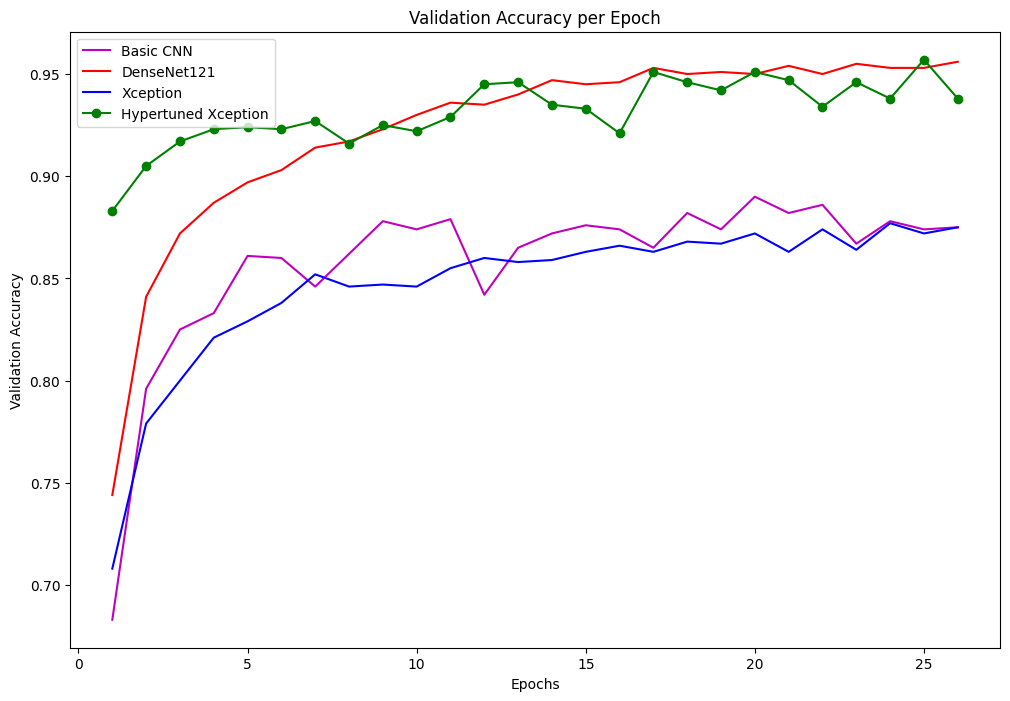

In [ ]:
# Calculate the number of epochs based on the shortest array
epochs = range(1, min(len(val_accuracy_fine_tune), len(val_accuracy_cnn), len(val_accuracy_densenet), len(val_accuracy_xception)) + 1)

# Print the lengths of the arrays to identify the mismatch
print(f"Length of val_accuracy_fine_tune: {len(val_accuracy_fine_tune)}")
print(f"Length of val_accuracy_cnn: {len(val_accuracy_cnn)}")
print(f"Length of val_accuracy_densenet: {len(val_accuracy_densenet)}")
print(f"Length of val_accuracy_xception: {len(val_accuracy_xception)}")

# Create the plot
plt.figure(figsize=(12, 8))

plt.plot(epochs, val_accuracy_cnn[:len(epochs)], 'm-', label='Basic CNN') # Slice the arrays to match the length of epochs
plt.plot(epochs, val_accuracy_densenet[:len(epochs)], 'r-', label='DenseNet121')
plt.plot(epochs, val_accuracy_xception[:len(epochs)], 'b-', label='Xception')
plt.plot(epochs, val_accuracy_fine_tune[:len(epochs)], 'g-o', label='Hypertuned Xception')

# Add titles and labels
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# Save and show the plot
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Length of val_accuracy_fine_tune: 27
Length of val_accuracy_cnn: 26
Length of val_accuracy_densenet: 30
Length of val_accuracy_xception: 30


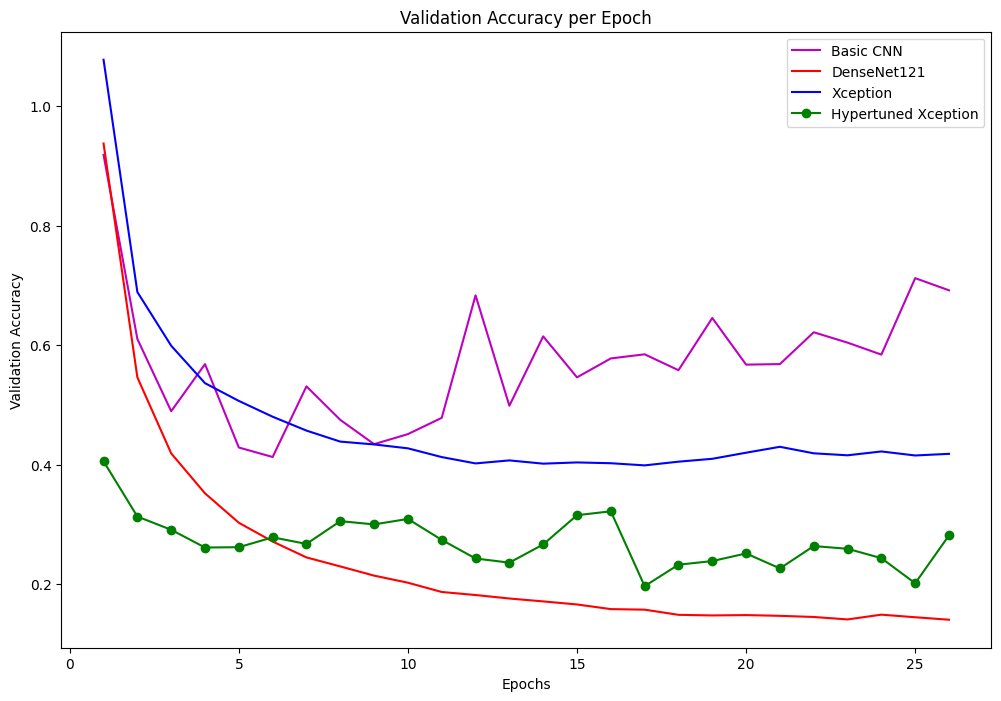

In [ ]:
# Calculate the number of epochs based on the shortest array
epochs = range(1, min(len(val_loss_fine_tune), len(val_loss_cnn), len(val_loss_densenet), len(val_loss_xception)) + 1)

# Print the lengths of the arrays to identify the mismatch
print(f"Length of val_accuracy_fine_tune: {len(val_loss_fine_tune)}")
print(f"Length of val_accuracy_cnn: {len(val_loss_cnn)}")
print(f"Length of val_accuracy_densenet: {len(val_loss_densenet)}")
print(f"Length of val_accuracy_xception: {len(val_loss_xception)}")

# Create the plot
plt.figure(figsize=(12, 8))

plt.plot(epochs, val_loss_cnn[:len(epochs)], 'm-', label='Basic CNN') # Slice the arrays to match the length of epochs
plt.plot(epochs, val_loss_densenet[:len(epochs)], 'r-', label='DenseNet121')
plt.plot(epochs, val_loss_xception[:len(epochs)], 'b-', label='Xception')
plt.plot(epochs, val_loss_fine_tune[:len(epochs)], 'g-o', label='Hypertuned Xception')

# Add titles and labels
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# Save and show the plot
plt.savefig('model_comparison_loss.png', dpi=300, bbox_inches='tight')
plt.show()